In [52]:
import re
import logging
import json
import urllib
import yaml
import pickle
import datetime
from IPython import get_ipython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
from scipy.optimize import curve_fit
%matplotlib inline
pylab.rcParams['figure.figsize'] = [17, 10]


In [3]:
main_data = pd.read_csv(
    'lw_survey__2016_lw_survey_public_release_3.csv',
    low_memory=False,
)

In [8]:
main_data.columns

Index(['startlanguage', 'GeneralPrivacy', 'ResearchConsent', 'Age', 'BirthSex',
       'BirthSex[other]', 'Gender', 'Gender[other]', 'Country',
       'Country[other]',
       ...
       'CharityDonations[8]', 'CharityDonations[9]', 'CharityDonations[10]',
       'CharityDonations[11]', 'CharityDonations[12]', 'CharityDonations[13]',
       'CharityDonations[14]', 'CharityDonations[15]', 'Vegetarian',
       'PreviousSurvey'],
      dtype='object', length=339)

In [57]:
blog_names = [
    "LessWrong", "SlateStarCodex", "Overcoming Bias",
    "Minding Our Way", "Agenty Duck", "Eliezer Yudkowsky's Facebook Page",
    "Luke Muehlhauser", "Gwern.net", "Siderea", "Ribbon Farm",
    "Bayesed And Confused", "The Unit Of Caring", "Givewell Blog",
    "Thing Of Things", "The Last Psychiatrist", "Hotel Concierge",
    "The View From Hell", "Xenosystems",
]
story_names = [
    "Harry Potter And The Methods Of Rationality",
    "Significant Digits", "Three Worlds Collide",
    "The Fable of the Dragon-Tyrant", "The World of Null-A",
    "Synthesis", "Worm", "Pact", "Twig", "Ra",
    "My Little Pony: Friendship Is Optimal",
    "Friendship Is Optimal: Caelum Est Conterrens", "Ender's Game",
    "The Diamond Age", "Consider Phlebas",
    "The Metamorphosis Of Prime Intellect",
    "Accelerando", "A Fire Upon The Deep",
]

community_names = [
    "LessWrong", "LessWrong Meetups", "LessWrong Facebook Group",
    "LessWrong Slack", "SlateStarCodex", "Rationalist Tumblr",
    "Rationalist Facebook", "Rationalist Twitter",
    "Effective Altruism Hub", "FortForecast",
    "Good Judgement(TM) Open", "PredictionBook", "Omnilibrium",
    "Hacker News", "#lesswrong on freenode",
    "#slatestarcodex on freenode", "#hplusroadmap on freenode",
    "#chapelperilous on freenode", "/r/rational", "/r/HPMOR",
    "/r/SlateStarCodex", "One or more private 'rationalist' groups",
]

that_weird_numbering_re = r'([0-9])?\[([0-9])\]$'


def weird_numbering_to_idx(name):
    match = re.search(that_weird_numbering_re, name)
    if not match:
        return
    val1, val2 = match.groups()
    res = int(val2) - 1
    if val1 is not None:
        res += 10 * (int(val1) - 1)
    return res

def make_column_mapping(name_re, titles, all_columns=main_data.columns, prefix=''):
    # NOTE: hopefully the original ordering
    columns = [name for name in all_columns if re.search(name_re, name)]
    assert len(columns) == len(titles), dict(found_num=len(columns), titles_num=len(titles), found=columns)
    return zip(columns, [prefix + title for title in titles])


column_mapping = {}
blog_column_re = r'^BlogsRead' + that_weird_numbering_re
column_mapping.update(make_column_mapping(blog_column_re, blog_names, prefix='Blog: '))
story_column_re = r'^StoriesRead' + that_weird_numbering_re
column_mapping.update(make_column_mapping(story_column_re, story_names, prefix='Story: '))
column_mapping.update(make_column_mapping('^ActiveMemberships\[[0-9]+\]$', community_names, prefix='Community: '))
column_mapping

{'ActiveMemberships[10]': 'Community: FortForecast',
 'ActiveMemberships[11]': 'Community: Good Judgement(TM) Open',
 'ActiveMemberships[12]': 'Community: PredictionBook',
 'ActiveMemberships[13]': 'Community: Omnilibrium',
 'ActiveMemberships[14]': 'Community: Hacker News',
 'ActiveMemberships[15]': 'Community: #lesswrong on freenode',
 'ActiveMemberships[16]': 'Community: #slatestarcodex on freenode',
 'ActiveMemberships[17]': 'Community: #hplusroadmap on freenode',
 'ActiveMemberships[18]': 'Community: #chapelperilous on freenode',
 'ActiveMemberships[19]': 'Community: /r/rational',
 'ActiveMemberships[1]': 'Community: LessWrong',
 'ActiveMemberships[20]': 'Community: /r/HPMOR',
 'ActiveMemberships[21]': 'Community: /r/SlateStarCodex',
 'ActiveMemberships[22]': "Community: One or more private 'rationalist' groups",
 'ActiveMemberships[2]': 'Community: LessWrong Meetups',
 'ActiveMemberships[3]': 'Community: LessWrong Facebook Group',
 'ActiveMemberships[4]': 'Community: LessWrong Sl

In [9]:
clusters_data = yaml.safe_load(open('lw_survey_clustered_1.yaml'))
clusters_data.keys()

dict_keys(['Cluster 1', 'Cluster 8', 'Cluster 3', 'Cluster 7', 'Cluster 5', 'Cluster 4', 'Cluster 6', 'Cluster 0', 'Cluster 2'])

In [54]:
sorted(list(clusters_data['Cluster 1'].keys()))

['Accelerando Answers',
 'Agenty Duck Answers',
 'Asexuality Answers',
 'Average ACT',
 'Average Age',
 'Average IQ',
 'Average IQAge',
 'Average SAT',
 'Average SAT2',
 'Bayesed And Confused Answers',
 'BirthSex Answers',
 'Children Answers',
 'Consider Phlebas Answers',
 'Country Answers',
 'EducationCredentials Answers',
 "Eliezer Yudkowsky's Facebook Page Answers",
 "Ender's Game Answers",
 'FamilyReligion Answers',
 'Friendship Is Optimal_ Caelum Est Conterrens Answers',
 'Gender Answers',
 'Givewell Blog Answers',
 'Gwern.net Answers',
 'Harry Potter And The Methods Of Rationality Answers',
 'Hotel Concierge Answers',
 'IQType Answers',
 'LessWrong Answers',
 'LivingWith Answers',
 'Luke Muehlhauser Answers',
 'Married Answers',
 'Minding Our Way Answers',
 'MoreChildren Answers',
 'My Little Pony_ Friendship Is Optimal Answers',
 'NumberPartners Answers',
 'Overcoming Bias Answers',
 'Pact Answers',
 'PoliticsShort Answers',
 'Profession Answers',
 'Ra Answers',
 'Race Answers',

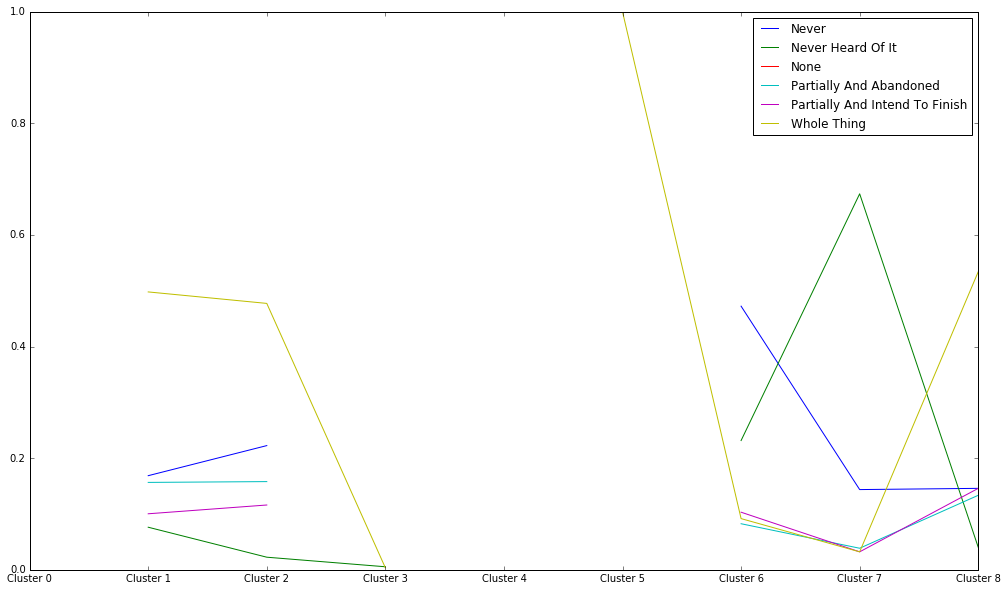

In [16]:
c1 = {key: val['Worm Answers'] for key, val in clusters_data.items()}
c1d = pd.DataFrame(c1)
c1d.transpose().plot()

In [58]:
[name for name in main_data.columns if name not in column_mapping]

['startlanguage',
 'GeneralPrivacy',
 'ResearchConsent',
 'Age',
 'BirthSex',
 'BirthSex[other]',
 'Gender',
 'Gender[other]',
 'Country',
 'Country[other]',
 'Race',
 'Race[other]',
 'SexualOrientation',
 'SexualOrientation[other]',
 'Asexuality',
 'RelationshipStyle',
 'RelationshipStyle[other]',
 'NumberPartners',
 'RelationshipGoals',
 'Married',
 'LivingWith',
 'LivingWith[other]',
 'Children',
 'MoreChildren',
 'WorkStatus[1]',
 'WorkStatus[2]',
 'WorkStatus[3]',
 'WorkStatus[4]',
 'WorkStatus[5]',
 'WorkStatus[6]',
 'WorkStatus[7]',
 'WorkStatus[8]',
 'WorkStatus[9]',
 'Profession',
 'Profession[other]',
 'EducationCredentials',
 'EducationCredentials[other]',
 'IQ',
 'IQAge',
 'IQType',
 'SAT',
 'SAT2',
 'ACT',
 'PoliticsShort',
 'ReligiousViews',
 'ReligionType',
 'ReligionType[other]',
 'FamilyReligion',
 'FamilyReligion[other]',
 'ReligiousBackground',
 'ReligiousBackground[other]',
 'MetaEthics',
 'ReferredBy',
 'ReferredBy[other]',
 'LessWrongUse',
 'LWUseFrequency',
 'LWL

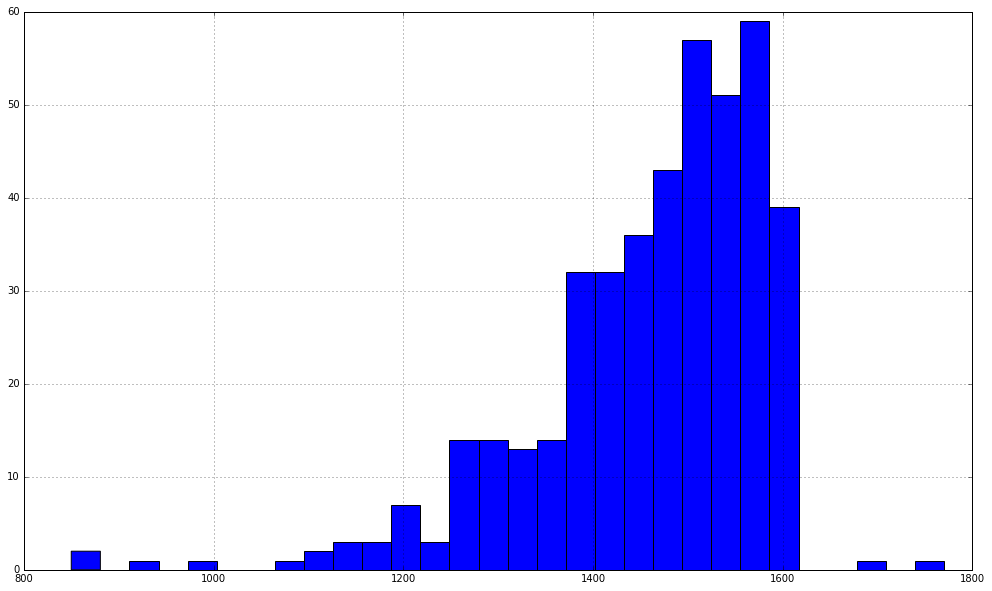

In [62]:
main_data['SAT'].hist(bins=30)  # some "general population" data here would be relevant

In [66]:
main_data.sample(40).rename(columns=column_mapping).transpose()

,1290,1671,83,1656,1929,234,601,1206,1122,730,...,1969,969,1487,1192,535,867,1227,16,2015,455
startlanguage,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
GeneralPrivacy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
ResearchConsent,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
Age,42,24,29,43,NaN,27,18,58,24,28,...,20,NaN,23,26,24,35,28,NaN,30,24
BirthSex,Male,Male,Male,Male,NaN,Male,Female,Male,Male,Male,...,Male,NaN,Male,Male,Male,Male,Male,NaN,Male,Male
BirthSex[other],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,Other,M (cisgender),M (cisgender),M (cisgender),NaN,M (cisgender),F (cisgender),M (cisgender),M (cisgender),M (cisgender),...,M (cisgender),NaN,M (cisgender),M (cisgender),M (cisgender),M (cisgender),M (cisgender),NaN,M (cisgender),M (cisgender)
Gender[other],Not sure what this question is meant to assess...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,United States,United States,Israel,United States,NaN,United States,United States,United Kingdom,United States,United States,...,United States,NaN,United States,United Kingdom,United States,United States,NaN,NaN,United States,United States
Country[other],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
